Setting seeds and configuring GPU...
Configured 1 GPU(s) with memory growth.

--- Preprocessing Step: Generating ELA images ---
Processing real images...
Saved 7437 ELA real images.
Processing fake images...
Saved 5123 ELA fake images.

Class Distribution in the full dataset:
label
0    7437
1    5123
Name: count, dtype: int64

Training Class Distribution:
label
0    4462
1    3074
Name: count, dtype: int64

Validation Class Distribution:
label
0    1487
1    1025
Name: count, dtype: int64

Test Class Distribution:
label
0    1488
1    1024
Name: count, dtype: int64

Class weights: {0: 0.8444643657552667, 1: 1.2257644762524398}

--- Setting up Data Augmentation and Generators ---
Creating generators for original images...
Found 7536 validated image filenames belonging to 2 classes.
Found 2512 validated image filenames belonging to 2 classes.
Found 2512 validated image filenames belonging to 2 classes.
Creating generators for ELA images...
Found 7536 validated image filenames belonging 

Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_orig (InputLayer)   │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ela (InputLayer)    │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50v2_orig           │ (None, 7, 7, 2048)     │     23,564,800 │ input_orig[0][0]       │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50

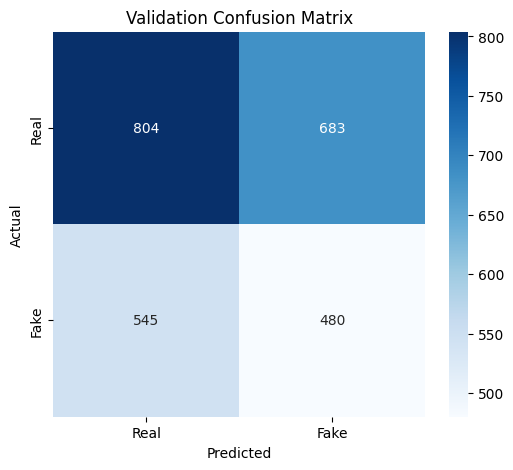

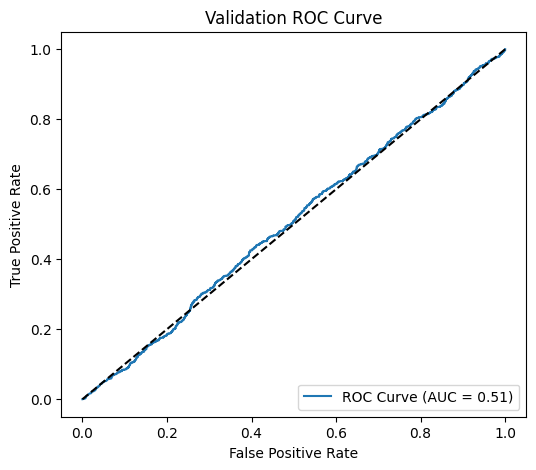

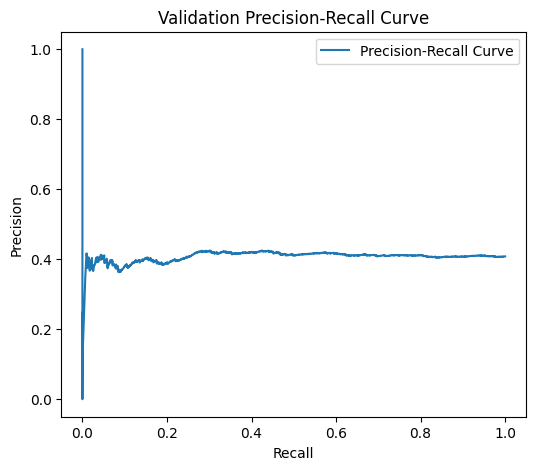


--- Evaluating on Test Set ---

Test Loss: 0.2486
Test Accuracy: 0.9224
Test Precision: 0.8546
Test Recall: 0.9756
Test F1-Score: 0.4542


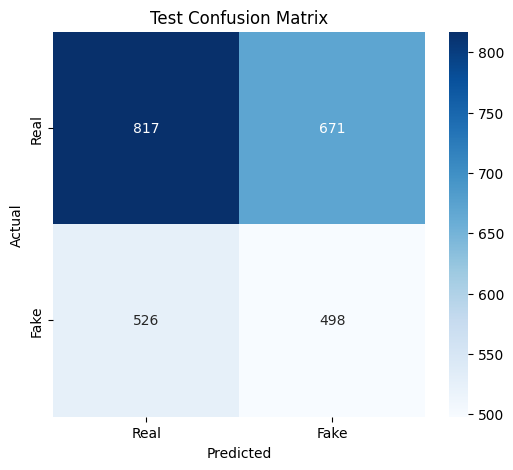

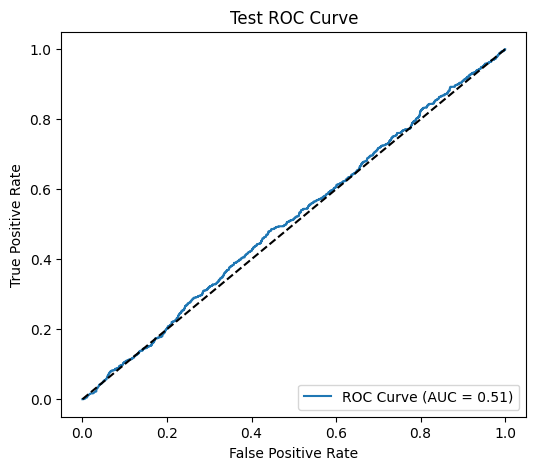

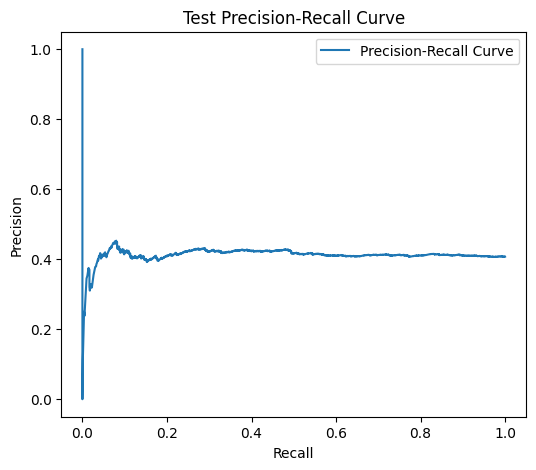

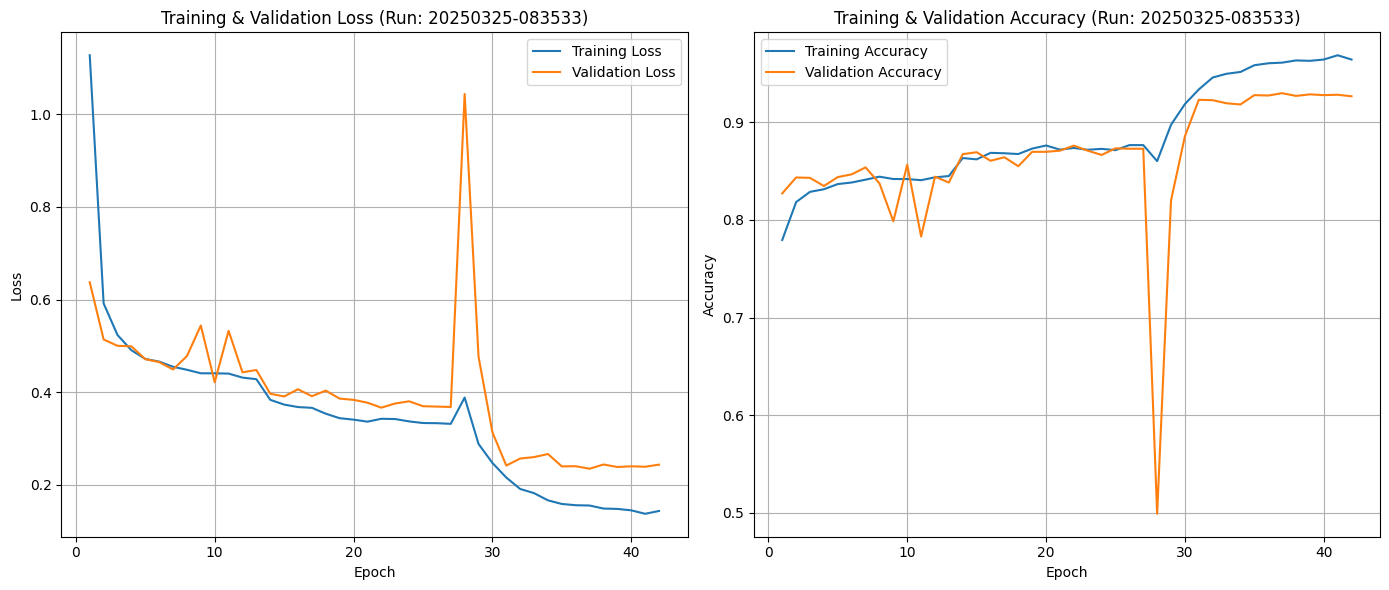


Final model saved as: /kaggle/working/final_model_20250325-083533.keras

Final Evaluation Metrics:
      Dataset      Loss  Accuracy  Precision    Recall  F1-Score
0  Validation  0.234833  0.929936   0.865004  0.981463  0.438757
1        Test  0.248579  0.922373   0.854577  0.975586  0.454172


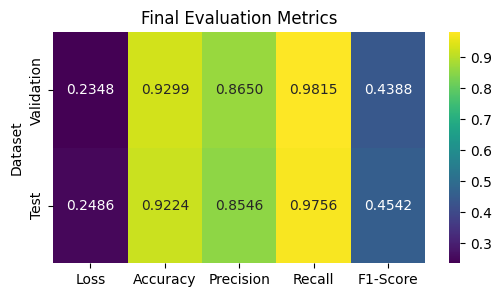

In [1]:
import tensorflow as tf
from tensorflow.keras import preprocessing, applications, layers, models, callbacks, regularizers, optimizers
from sklearn import model_selection, metrics as skmetrics, utils as skutils
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance
import imghdr
import random
import tempfile

# ================================
# 0. Setup & Configuration
# ================================
print("Setting seeds and configuring GPU...")
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Configured {len(gpus)} GPU(s) with memory growth.")
    except Exception as e:
        print(f"Error setting GPU memory growth: {e}")

# ================================
# 1. Helper Functions
# ================================

def convert_to_ela_image(path, quality=90):
    """Convert an image to its ELA version using a temporary file."""
    try:
        image = Image.open(path).convert('RGB')
        with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as temp_file:
            temp_filename = temp_file.name
        image.save(temp_filename, 'JPEG', quality=quality)
        temp_image = Image.open(temp_filename)
        ela_image = ImageChops.difference(image, temp_image)
        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema]) or 1
        scale = 255.0 / max_diff
        ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
        os.remove(temp_filename)  # Clean up temporary file
        return ela_image
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

def process_and_save_ela(image_path, save_dir, size=(224, 224)):
    """Process an image to ELA and save it."""
    ela_image = convert_to_ela_image(image_path, quality=90)
    if ela_image is None:
        return None
    ela_image = ela_image.resize(size)
    filename = os.path.basename(image_path)
    save_path = os.path.join(save_dir, filename)
    ela_image.save(save_path)
    return save_path

def is_image(filepath):
    """Check if a file is an image."""
    return imghdr.what(filepath) is not None

# ================================
# 2. Preprocessing: Generate ELA Images & DataFrame
# ================================
print("\n--- Preprocessing Step: Generating ELA images ---")
base_dir = '/kaggle/input/casia-dataset/CASIA2'
real_dir = os.path.join(base_dir, 'Au')
fake_dir = os.path.join(base_dir, 'Tp')
ela_real_dir = '/kaggle/working/ela_real'
ela_fake_dir = '/kaggle/working/ela_fake'
os.makedirs(ela_real_dir, exist_ok=True)
os.makedirs(ela_fake_dir, exist_ok=True)

print("Processing real images...")
real_ela_paths = []
real_images = []
for filename in os.listdir(real_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.tif')):
        image_path = os.path.join(real_dir, filename)
        real_images.append(image_path)
        save_path = process_and_save_ela(image_path, ela_real_dir)
        if save_path:
            real_ela_paths.append(save_path)
print(f"Saved {len(real_ela_paths)} ELA real images.")

print("Processing fake images...")
fake_ela_paths = []
fake_images = []
for filename in os.listdir(fake_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.tif')):
        image_path = os.path.join(fake_dir, filename)
        fake_images.append(image_path)
        save_path = process_and_save_ela(image_path, ela_fake_dir)
        if save_path:
            fake_ela_paths.append(save_path)
print(f"Saved {len(fake_ela_paths)} ELA fake images.")

# Create DataFrame with original and ELA image paths and labels
all_images = real_images + fake_images
all_ela_images = real_ela_paths + fake_ela_paths
all_labels = [0]*len(real_images) + [1]*len(fake_images)
df = pd.DataFrame({'filename': all_images, 'ela_filename': all_ela_images, 'label': all_labels})
df['label'] = df['label'].astype(str)

print("\nClass Distribution in the full dataset:")
print(df['label'].value_counts())

# Split dataset into train, validation, and test
train_df, temp_df = model_selection.train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
val_df, test_df = model_selection.train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print("\nTraining Class Distribution:")
print(train_df['label'].value_counts())
print("\nValidation Class Distribution:")
print(val_df['label'].value_counts())
print("\nTest Class Distribution:")
print(test_df['label'].value_counts())

# Compute class weights
train_df['label_int'] = train_df['label'].astype(int)
class_weights = skutils.class_weight.compute_class_weight('balanced', classes=[0,1], y=train_df['label_int'])
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)

# ================================
# 3. Data Augmentation & Generators
# ================================
print("\n--- Setting up Data Augmentation and Generators ---")
batch_size = 32
target_size = (224, 224)

train_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    channel_shift_range=0.1,
    fill_mode='nearest'
)
val_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255)

print("Creating generators for original images...")
train_generator_orig = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='filename', y_col='label',
    target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=True, seed=42
)
val_generator_orig = val_datagen.flow_from_dataframe(
    dataframe=val_df, x_col='filename', y_col='label',
    target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=False
)
test_generator_orig = test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='filename', y_col='label',
    target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=False
)

print("Creating generators for ELA images...")
train_generator_ela = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='ela_filename', y_col='label',
    target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=True, seed=42
)
val_generator_ela = val_datagen.flow_from_dataframe(
    dataframe=val_df, x_col='ela_filename', y_col='label',
    target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=False
)
test_generator_ela = test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='ela_filename', y_col='label',
    target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=False
)

def multi_input_generator(gen_orig, gen_ela, class_weights=None):
    while True:
        orig_batch, labels = next(gen_orig)
        ela_batch, _ = next(gen_ela)
        if class_weights is not None:
            sample_weights = np.array([class_weights[int(label)] for label in labels])
            yield ((orig_batch, ela_batch), labels, sample_weights)
        else:
            yield ((orig_batch, ela_batch), labels)

# Create multi-input generators
train_multi_gen = multi_input_generator(train_generator_orig, train_generator_ela, class_weights=class_weights)
val_multi_gen = multi_input_generator(val_generator_orig, val_generator_ela, class_weights=None)
test_multi_gen = multi_input_generator(test_generator_orig, test_generator_ela, class_weights=None)

# Define output signatures for tf.data.Dataset
train_output_signature = (
    (
        tf.TensorSpec(shape=(None, target_size[0], target_size[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, target_size[0], target_size[1], 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)
val_output_signature = (
    (
        tf.TensorSpec(shape=(None, target_size[0], target_size[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, target_size[0], target_size[1], 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# Wrap generators with tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(lambda: train_multi_gen, output_signature=train_output_signature).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_generator(lambda: val_multi_gen, output_signature=val_output_signature).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_generator(lambda: test_multi_gen, output_signature=val_output_signature).prefetch(tf.data.AUTOTUNE)

# ================================
# 4. Model Definition
# ================================
print("\n--- Building the Multi-Input Model ---")
input_orig = layers.Input(shape=(target_size[0], target_size[1], 3), name='input_orig')
input_ela = layers.Input(shape=(target_size[0], target_size[1], 3), name='input_ela')

# Try loading EfficientNetV2B0 for both branches; fallback to ResNet50V2 if needed
try:
    base_model_orig = applications.EfficientNetV2B0(
        weights='imagenet', include_top=False, name='efficientnetv2b0_orig'
    )(input_orig)
    base_model_ela = applications.EfficientNetV2B0(
        weights='imagenet', include_top=False, name='efficientnetv2b0_ela'
    )(input_ela)
    print("Successfully loaded EfficientNetV2B0 for both branches.")
except Exception as e:
    print(f"EfficientNetV2B0 load failed: {e}")
    print("Falling back to ResNet50V2.")
    base_model_orig = applications.ResNet50V2(
        weights='imagenet', include_top=False, name='resnet50v2_orig'
    )(input_orig)
    base_model_ela = applications.ResNet50V2(
        weights='imagenet', include_top=False, name='resnet50v2_ela'
    )(input_ela)

# Global average pooling for each branch
x_orig = layers.GlobalAveragePooling2D()(base_model_orig)
x_ela = layers.GlobalAveragePooling2D()(base_model_ela)

# Concatenate features from both branches
x = layers.Concatenate()([x_orig, x_ela])
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = models.Model(inputs=[input_orig, input_ela], outputs=predictions)

# Freeze the pre-trained base model layers (all layers with these names)
for layer in model.layers:
    if 'efficientnetv2b0' in layer.name or 'resnet50v2' in layer.name:
        layer.trainable = False
print("Base model layers frozen.")

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
model.summary(print_fn=lambda x: print(x))

# ================================
# 5. Callbacks Setup
# ================================
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint(f'/kaggle/working/best_model_{timestamp}.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
tensorboard_cb = callbacks.TensorBoard(log_dir=f"/kaggle/working/tb_logs/{timestamp}", histogram_freq=1)
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard_cb]

# ================================
# 6. Training Phase 1: Train Top Layers
# ================================
print("\n--- Training Phase 1: Training Top Layers ---")
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_generator_orig),
    epochs=50,
    validation_data=val_dataset,
    validation_steps=len(val_generator_orig),
    callbacks=callbacks_list
)

# ================================
# 7. Fine-Tuning Phase: Unfreeze More Layers
# ================================
print("\n--- Fine-Tuning Phase: Unfreezing Base Model Layers ---")
for layer in model.layers:
    if 'efficientnetv2b0' in layer.name or 'resnet50v2' in layer.name:
        layer.trainable = True
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
history_fine = model.fit(
    train_dataset,
    steps_per_epoch=len(train_generator_orig),
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_generator_orig),
    callbacks=callbacks_list
)

# Combine training histories for plotting
def combine_history(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

combined_history = combine_history(history, history_fine)

# ================================
# 8. Advanced Evaluation
# ================================
def evaluate_model(dataset, df, batch_size=32, name="Evaluation"):
    steps = (len(df) + batch_size - 1) // batch_size
    loss, accuracy, precision, recall = model.evaluate(dataset, steps=steps, verbose=0)
    print(f'\n{name} Loss: {loss:.4f}')
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(f'{name} Precision: {precision:.4f}')
    print(f'{name} Recall: {recall:.4f}')

    y_pred_prob = model.predict(dataset, steps=steps, verbose=0)
    num_samples = min(steps * batch_size, len(df))
    y_pred = (y_pred_prob[:num_samples] > 0.5).astype(int).flatten()
    y_true = df['label'].astype(int).values[:num_samples]
    f1 = skmetrics.f1_score(y_true, y_pred)
    print(f'{name} F1-Score: {f1:.4f}')

    # Confusion Matrix
    cm = skmetrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = skmetrics.roc_curve(y_true, y_pred_prob[:num_samples])
    roc_auc = skmetrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = skmetrics.precision_recall_curve(y_true, y_pred_prob[:num_samples])
    plt.figure(figsize=(6, 5))
    plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend(loc='upper right')
    plt.show()

    return {'Loss': loss, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

print("\n--- Evaluating on Validation Set ---")
val_metrics = evaluate_model(val_dataset, val_df, name="Validation")
print("\n--- Evaluating on Test Set ---")
test_metrics = evaluate_model(test_dataset, test_df, name="Test")

# ================================
# 9. Training History Plots
# ================================
epochs = range(1, len(combined_history['loss']) + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, combined_history['loss'], label='Training Loss')
plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training & Validation Loss (Run: {timestamp})')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, combined_history['accuracy'], label='Training Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training & Validation Accuracy (Run: {timestamp})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ================================
# 10. Save the Final Model
# ================================
final_model_path = f'/kaggle/working/final_model_{timestamp}.keras'
model.save(final_model_path)
print(f"\nFinal model saved as: {final_model_path}")

# ================================
# 11. Final Evaluation Metrics Table
# ================================
final_metrics = {
    'Dataset': ['Validation', 'Test'],
    'Loss': [val_metrics['Loss'], test_metrics['Loss']],
    'Accuracy': [val_metrics['Accuracy'], test_metrics['Accuracy']],
    'Precision': [val_metrics['Precision'], test_metrics['Precision']],
    'Recall': [val_metrics['Recall'], test_metrics['Recall']],
    'F1-Score': [val_metrics['F1-Score'], test_metrics['F1-Score']]
}
metrics_table = pd.DataFrame(final_metrics)
print("\nFinal Evaluation Metrics:")
print(metrics_table)
plt.figure(figsize=(6,3))
sns.heatmap(metrics_table.set_index('Dataset'), annot=True, cmap='viridis', fmt=".4f")
plt.title("Final Evaluation Metrics")
plt.show()
